In [23]:
import numpy as np
import pandas as pd

from src.evaluation_tool.layered_tool import FairKit

# Demonstration of FairKit

The following notebook is a demonstration of the FairKit class, which can be used for evaluating the fairness of a binary classification model.

The FairKit class is a 3-layer toolkit for analysing and understanding how much unfairness is present in predictions from a given predictive algorithm. It analyses the unfairness by subgroups dictated by a sensitive attribute such as sex or race. The three layers of FairKit each returns a visualization and the data behind. Moreover, it is designed such that each layer should nuance the analysis and aid the user to a deeper understanding of their predictions. $\textcolor{red}{\text{TODO: We might need something about 'please read here for thorough walktrough'}}$

## Data 
This demonstration will use the canonical COMPAS dataset, which were analyzed in ProPublica's [article](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) about machine bias in criminal sentencing. 

To shortly summarize: the COMPAS algorithm assigns a decile score between 1 and 10 to a criminal. A score above 5 means that the criminal is considered to have medium(6-8) or high(9-10) risk of comitting another crime within two years. The target variable of the binary classification of the $\text{i}^{\text{th}}$ criminal is given by
$$
\text{pred}_i = \begin{cases}
    0 &\text{decile\_score}_i <= 5\\
    1 &\text{decile\_score}_i > 5
\end{cases}
$$

In [24]:
# Loading Processed Data Set
compas_file_path = 'data/processed/compas/compas-scores-two-years-pred.csv'
compas = pd.read_csv(compas_file_path)
compas.head(5)

,id,sex,age,age_cat,race,decile_score,score_text,two_year_recid,pred
0,3,Male,34,25 - 45,African-American,3,Low,1,False
1,4,Male,24,Less than 25,African-American,4,Low,1,False
2,8,Male,41,25 - 45,Caucasian,6,Medium,1,True
3,10,Female,39,25 - 45,Caucasian,1,Low,0,False
4,14,Male,27,25 - 45,Caucasian,4,Low,0,False


## Initialization of Class
The following section shows how the FairKit class is initialized. To initialize the class one must specify: 

* **data**: DataFrame containing data used for evaluation
*  **y_name**: Name of target variable
* **y_hat_name**: Name of binary output variable
* **r_name**: Name of variable containing scores (scores must be within [0,1])
* **a_name**: Name of sensitive variable 
* **w_fp**: False positive error rate
* **model_name**: Name of the model or dataset used. Is used for plot titles. (Optional)
 

The COMPAS dataset will be analyzed wrt. discrimination by race. Note that the dataset has been filtered such that it only contains the races "African-American" and "Caucasian". Because decile scores range from 1-10 they must be divided by 10 prior to initializing the class.  

In [25]:
compas = compas.assign(decile_score = lambda x: x.decile_score/10)

Then the data is ready for the class to be initialized. The False Positive Error weight $w_{FP} \in [0,1]$ balances the severity of recieving a false positive vs. a false negative. Because it has servere consequences to be classified as a possible recidivist it is suitable to choose a high weight such as $w_{FP} = 0.9$.

In [27]:
compas_w_fp = 0.9
fair_compas = FairKit(
    data = compas,
    y_name = "two_year_recid", 
    y_hat_name = "pred", 
    a_name = "race", 
    r_name = "decile_score",
    w_fp = compas_w_fp,
    model_name='COMPAS Decile Scores')

## Layer 1 - The Quick Overview

The first layer should be used to get a really quick overview wheter there is unfairness present in the predictions and how much. To this end the maximum relative difference in percent between the sensitive groups' weighted misclassification rates (WMR) is used.

WMR of sensitive group $a$ is defined as
$$
    \textit{WMR}_a = c(w_{FP})\cdot\frac{w_{FP} FP_a + (1-w_{FP})FN_a}{N_a},
$$
where $FP_a$ is the number of false positives in group $a$, $FN_a$ is the number of false negatives in group $a$, $N_a$ is the number of classified observations belonging to group $a$, and $w_{FP}$ is the weight indicating the severity of a false positive. $c(w_{FP})$ is a normalization constant ensuring $\textit{WMR} \in [0,1]$

The results from the first layer of FairKit is accessed by:

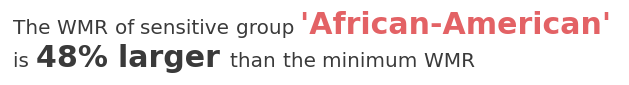

In [31]:
layer1_output_data = fair_compas.layer_1()

In [43]:
layer1_output_data

,grp,n,weighted_misclassification_ratio
0,African-American,2682,47.877821
1,Caucasian,1829,0.000000


From the illustration above it is seen that the group "African-American" sees a 48% larger WMR (weighted misclassification rate) compared to the group with the smallest WMR. From the table it is possible to see which group has the smallest $\textit{WMR}$ i.e. "Caucasian" with a weighted misclassification ratio of 0%. If there where more races in the data the table would have included more rows, but the illustration only highlights the largest relative gap. This is meant to be a red flag indicating to the user that the highlighted group has an unfair amount of misclassifications.

## Layer 2 - The Comprehensive Overview

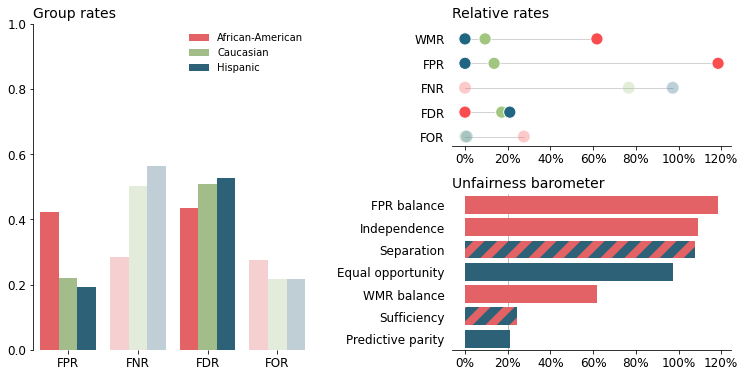

In [5]:
rates, relative_rates, barometer = fair_compas.layer_2()

In [6]:
# Data from the layer
relative_rates

,grp,rate,rate_val,relative_rate
0,African-American,FDR,0.434282,0.000000
1,Caucasian,FDR,0.509025,17.210811
2,Hispanic,FDR,0.525424,20.986806
3,African-American,FNR,0.285103,0.000000
4,Caucasian,FNR,0.503650,76.655488
5,Hispanic,FNR,0.562500,97.297297
6,African-American,FOR,0.276119,27.555159
7,Caucasian,FOR,0.216471,0.000000
8,Hispanic,FOR,0.218182,0.790514
9,African-American,FPR,0.423382,118.519623


In [7]:
barometer

,criterion,relative_rate,discriminated_grp
1,FPR balance,118.519623,[African-American]
2,Independence,108.940962,[African-American]
4,Separation,107.908460,"[Hispanic, African-American]"
0,Equal opportunity,97.297297,[Hispanic]
6,WMR balance,61.789709,[African-American]
5,Sufficiency,24.270982,"[Hispanic, African-American]"
3,Predictive parity,20.986806,[Hispanic]


## Layer 3 - Diving into Specifics

Based on layer 2 it is possible to investigate further where the unfairness stems from. Layer 3 currently includes the following methods:
- `w_fp_influence`: Shows how different settings of `w_fp` influence the weighted misclassification ratio or rate. 
- `roc_curves`: ROC curves for each sensitive group. Suitable if the unfairness barometer shows high disparities in *separation*, *FPR balance* or *Equal opportunity*. 
- `calibration`: Calibration curve for each sensitive group. Suitable if the unfairness barometer shows high disparities in *sufficiency*.
- `confusion_matrix`: Display a confusion matrix for each sensitive group. 
- `independence_check`: Fraction of individuals predicted to most unfavored outcome. Suitable if there are high disparities in *independence*. 

In this example using COMPAS, independence and separation shows the biggest differences between groups, so the methods `roc_curves` and `independence_check` are used. 

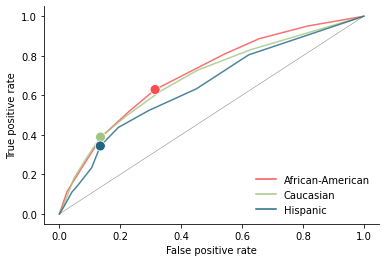

In [8]:
# Looking into roc curves
roc = fair_compas.layer_3(method = 'roc_curves')

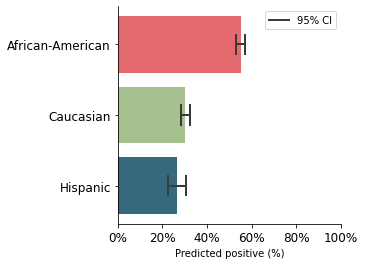

In [9]:
independence = fair_compas.layer_3(method = 'independence_check')

## The remaining plots in layer 3

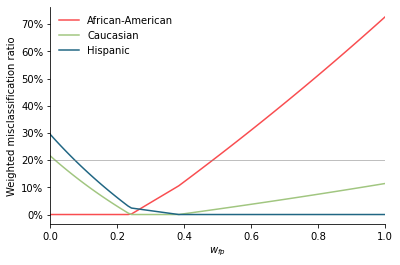

In [10]:
fair_compas.layer_3(method = 'w_fp_influence')

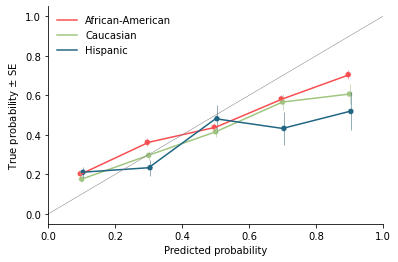

In [11]:
cal = fair_compas.layer_3(method = 'calibration')

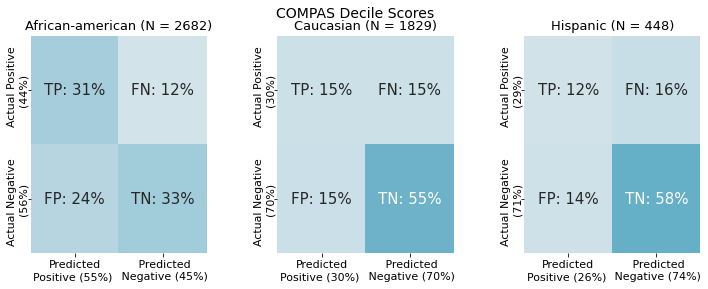

In [12]:
confusion = fair_compas.layer_3(method = 'confusion_matrix')